# Cleaning US Census Data

You just got hired as a Data Analyst at the Census Bureau, which collects census data and creates interesting visualizations and insights from it.

The person who had your job before you left you all the data they had for the most recent census. It is in multiple `csv` files. They didn't use pandas, they would just look through these `csv` files manually whenever they wanted to find something. Sometimes they would copy and paste certain numbers into Excel to make charts.

The thought of it makes you shiver. This is not scalable or repeatable.

Your boss wants you to make some scatterplots and histograms by the end of the day. Can you get this data into `pandas` and into reasonable shape so that you can make these histograms?

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob

import warnings
warnings.filterwarnings("ignore")

## Inspect the Data!

1. The first visualization your boss wants you to make is a scatterplot that shows average income in a state vs proportion of women in that state.

   Open some of the census `csv` files that came with the kit you downloaded. How are they named? What kind of information do they hold? Will they help us make this graph?

2. It will be easier to inspect this data once we have it in a DataFrame. You can't even call `.head()` on these `csv`s! How are you supposed to read them?

   Using `glob`, loop through the census files available and load them into DataFrames. Then, concatenate all of those DataFrames together into one DataFrame, called something like `us_census`.

In [2]:
files = glob.glob("states*.csv")

states_list = []
for filename in files:
    data = pd.read_csv(filename)
    states_list.append(data)

us_census = pd.concat(states_list, axis=0, ignore_index=True)
us_census = us_census.drop(columns="Unnamed: 0", axis=1)

3. Look at the `.columns` and the `.dtypes` of the `us_census` DataFrame. Are those datatypes going to hinder you as you try to make histograms?

In [3]:
us_census.columns

Index(['State', 'TotalPop', 'Hispanic', 'White', 'Black', 'Native', 'Asian',
       'Pacific', 'Income', 'GenderPop'],
      dtype='object')

In [4]:
us_census.dtypes

State        object
TotalPop      int64
Hispanic     object
White        object
Black        object
Native       object
Asian        object
Pacific      object
Income       object
GenderPop    object
dtype: object

4. Look at the `head()` of the DataFrame so that you can understand why some of these `dtypes` are objects instead of integers or floats.

   Start to make a plan for how to convert these columns into the right types for manipulation.

In [5]:
us_census.head()

,State,TotalPop,Hispanic,White,Black,Native,Asian,Pacific,Income,GenderPop
0,Rhode Island,1053661,13.36%,74.33%,5.68%,0.35%,3.25%,0.04%,"$59,125.27",510388M_543273F
1,South Carolina,4777576,5.06%,62.89%,28.75%,0.29%,1.25%,0.05%,"$46,296.81",2322409M_2455167F
2,South Dakota,843190,3.24%,82.50%,1.42%,9.42%,1.02%,0.04%,"$51,805.41",423477M_419713F
3,Tennessee,6499615,4.72%,73.49%,18.28%,0.23%,1.41%,0.04%,"$47,328.08",3167756M_3331859F
4,Texas,26538614,38.05%,44.69%,11.65%,0.26%,3.67%,0.07%,"$55,874.52",13171316M_13367298F


## Regex to the Rescue

5. Use regex to turn the `Income` column into a format that is ready for conversion into a numerical type.

In [6]:
us_census["Income"] = us_census["Income"].str.replace("[\$,]", "", regex=True)
us_census["Income"] = pd.to_numeric(us_census["Income"])
us_census.dtypes

State         object
TotalPop       int64
Hispanic      object
White         object
Black         object
Native        object
Asian         object
Pacific       object
Income       float64
GenderPop     object
dtype: object

6. Look at the `GenderPop` column. We are going to want to separate this into two columns, the `Men` column, and the `Women` column.

   Split the column into those two new columns using `str.split` and separating out those results.

In [7]:
us_census.head()

,State,TotalPop,Hispanic,White,Black,Native,Asian,Pacific,Income,GenderPop
0,Rhode Island,1053661,13.36%,74.33%,5.68%,0.35%,3.25%,0.04%,59125.27,510388M_543273F
1,South Carolina,4777576,5.06%,62.89%,28.75%,0.29%,1.25%,0.05%,46296.81,2322409M_2455167F
2,South Dakota,843190,3.24%,82.50%,1.42%,9.42%,1.02%,0.04%,51805.41,423477M_419713F
3,Tennessee,6499615,4.72%,73.49%,18.28%,0.23%,1.41%,0.04%,47328.08,3167756M_3331859F
4,Texas,26538614,38.05%,44.69%,11.65%,0.26%,3.67%,0.07%,55874.52,13171316M_13367298F


In [8]:
gender_split = us_census["GenderPop"].str.split("_")
gender_split[0][0]
men = []
women = []

for man, woman in gender_split:
    men.append(man)
    women.append(woman)

us_census["Men"] = men
us_census["Women"] = women
us_census.head() 

,State,TotalPop,Hispanic,White,Black,Native,Asian,Pacific,Income,GenderPop,Men,Women
0,Rhode Island,1053661,13.36%,74.33%,5.68%,0.35%,3.25%,0.04%,59125.27,510388M_543273F,510388M,543273F
1,South Carolina,4777576,5.06%,62.89%,28.75%,0.29%,1.25%,0.05%,46296.81,2322409M_2455167F,2322409M,2455167F
2,South Dakota,843190,3.24%,82.50%,1.42%,9.42%,1.02%,0.04%,51805.41,423477M_419713F,423477M,419713F
3,Tennessee,6499615,4.72%,73.49%,18.28%,0.23%,1.41%,0.04%,47328.08,3167756M_3331859F,3167756M,3331859F
4,Texas,26538614,38.05%,44.69%,11.65%,0.26%,3.67%,0.07%,55874.52,13171316M_13367298F,13171316M,13367298F


7. Convert both of the columns into numerical datatypes.

   There is still an `M` or an `F` character in each entry! We should remove those before we convert.

In [9]:
us_census["Men"] = us_census["Men"].str.replace(".$", "", regex=True)
us_census["Women"] = us_census["Women"].str.replace(".$", "", regex=True)
us_census["Men"] = pd.to_numeric(us_census["Men"])
us_census["Women"] = pd.to_numeric(us_census["Women"])

us_census.dtypes

State         object
TotalPop       int64
Hispanic      object
White         object
Black         object
Native        object
Asian         object
Pacific       object
Income       float64
GenderPop     object
Men            int64
Women        float64
dtype: object

In [10]:
us_census[us_census["Women"].isna()]

,State,TotalPop,Hispanic,White,Black,Native,Asian,Pacific,Income,GenderPop,Men,Women
12,Maryland,5930538,8.47%,52.68%,30.68%,0.20%,5.33%,0.04%,78765.40,2872643M_F,2872643,NaN
19,Montana,1014699,3.27%,86.42%,0.43%,7.06%,0.57%,0.07%,47645.68,510163M_F,510163,NaN
47,Maryland,5930538,8.47%,52.68%,30.68%,0.20%,5.33%,0.04%,78765.40,2872643M_F,2872643,NaN


8. Now you should have the columns you need to make the graph and make sure your boss does not slam a ruler angrily on your desk because you've wasted your whole day cleaning your data with no results to show!

   Use matplotlib to make a scatterplot!
   
   ```py
   plt.scatter(the_women_column, the_income_column)
   ```
   
   Remember to call `plt.show()` to see the graph!

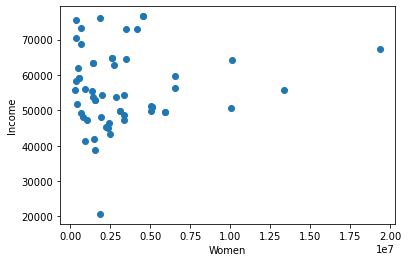

In [11]:
plt.scatter(us_census["Women"], us_census["Income"])
plt.xlabel("Women")
plt.ylabel("Income")
plt.show()

9. You want to double check your work. You know from experience that these monstrous csv files probably have `nan` values in them! Print out your column with the number of women per state to see.

   We can fill in those `nan`s by using pandas' `.fillna()` function.
   
   You have the `TotalPop` per state, and you have the `Men` per state. As an estimate for the `nan` values in the `Women` column, you could use the `TotalPop` of that state minus the `Men` for that state.
   
   Print out the `Women` column after filling the `nan` values to see if it worked!

In [12]:
us_census["Women"] = us_census["Women"].fillna(us_census["TotalPop"] - us_census["Men"])
us_census["Women"].isna().sum()

0

10. We forgot to check for duplicates! Use `.duplicated()` on your `census` DataFrame to see if we have duplicate rows in there.

In [13]:
us_census.duplicated().sum()

9

11. Drop those duplicates using the `.drop_duplicates()` function.

In [14]:
us_census = us_census.drop_duplicates()

12. Make the scatterplot again. Now, it should be perfect! Your job is secure, for now.

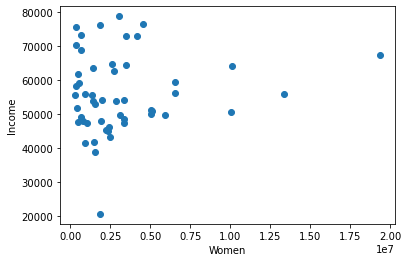

In [15]:
plt.scatter(us_census["Women"], us_census["Income"])
plt.xlabel("Women")
plt.ylabel("Income")
plt.show()

## Histogram of Races

13. Now your boss wants you to make a bunch of histograms out of the race data that you have. Look at the `.columns` again to see what the race categories are.

In [16]:
us_census.columns

Index(['State', 'TotalPop', 'Hispanic', 'White', 'Black', 'Native', 'Asian',
       'Pacific', 'Income', 'GenderPop', 'Men', 'Women'],
      dtype='object')

In [17]:
us_census.head()

,State,TotalPop,Hispanic,White,Black,Native,Asian,Pacific,Income,GenderPop,Men,Women
0,Rhode Island,1053661,13.36%,74.33%,5.68%,0.35%,3.25%,0.04%,59125.27,510388M_543273F,510388,543273.0
1,South Carolina,4777576,5.06%,62.89%,28.75%,0.29%,1.25%,0.05%,46296.81,2322409M_2455167F,2322409,2455167.0
2,South Dakota,843190,3.24%,82.50%,1.42%,9.42%,1.02%,0.04%,51805.41,423477M_419713F,423477,419713.0
3,Tennessee,6499615,4.72%,73.49%,18.28%,0.23%,1.41%,0.04%,47328.08,3167756M_3331859F,3167756,3331859.0
4,Texas,26538614,38.05%,44.69%,11.65%,0.26%,3.67%,0.07%,55874.52,13171316M_13367298F,13171316,13367298.0


14. Try to make a histogram for each one!

    You will have to get the columns into the numerical format, and those percentage signs will have to go.
    
    Don't forget to fill the `nan` values with something that makes sense! You probably dropped the duplicate rows when making your last graph, but it couldn't hurt to check for duplicates again.

In [18]:
column_list = ["Hispanic", "White", "Black", "Native", "Asian", "Pacific"]
def parse_data(column_list):
    for column in column_list:
        us_census[column] = us_census[column].str.replace("\%", "", regex=True)
        us_census[column] = pd.to_numeric(us_census[column])

In [19]:
parse_data(column_list)
us_census.head()

,State,TotalPop,Hispanic,White,Black,Native,Asian,Pacific,Income,GenderPop,Men,Women
0,Rhode Island,1053661,13.36,74.33,5.68,0.35,3.25,0.04,59125.27,510388M_543273F,510388,543273.0
1,South Carolina,4777576,5.06,62.89,28.75,0.29,1.25,0.05,46296.81,2322409M_2455167F,2322409,2455167.0
2,South Dakota,843190,3.24,82.50,1.42,9.42,1.02,0.04,51805.41,423477M_419713F,423477,419713.0
3,Tennessee,6499615,4.72,73.49,18.28,0.23,1.41,0.04,47328.08,3167756M_3331859F,3167756,3331859.0
4,Texas,26538614,38.05,44.69,11.65,0.26,3.67,0.07,55874.52,13171316M_13367298F,13171316,13367298.0


In [20]:
us_census.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51 entries, 0 to 58
Data columns (total 12 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   State      51 non-null     object 
 1   TotalPop   51 non-null     int64  
 2   Hispanic   51 non-null     float64
 3   White      51 non-null     float64
 4   Black      51 non-null     float64
 5   Native     51 non-null     float64
 6   Asian      51 non-null     float64
 7   Pacific    47 non-null     float64
 8   Income     51 non-null     float64
 9   GenderPop  51 non-null     object 
 10  Men        51 non-null     int64  
 11  Women      51 non-null     float64
dtypes: float64(8), int64(2), object(2)
memory usage: 5.2+ KB


In [21]:
us_census[us_census["Pacific"].isna()]

,State,TotalPop,Hispanic,White,Black,Native,Asian,Pacific,Income,GenderPop,Men,Women
34,North Dakota,721640,2.83,87.45,1.28,5.65,0.96,NaN,58188.11,367963M_353677F,367963,353677.0
43,Kansas,2892987,11.64,75.96,6.57,0.73,2.33,NaN,53885.61,1439862M_1453125F,1439862,1453125.0
48,Colorado,5278906,20.78,69.90,3.55,0.57,2.66,NaN,64657.80,2648667M_2630239F,2648667,2630239.0
50,Delaware,926454,8.82,64.63,20.74,0.26,3.27,NaN,61827.98,448413M_478041F,448413,478041.0


In [22]:
us_census["Pacific"] = us_census["Pacific"].fillna(100 - (us_census["Hispanic"] + us_census["White"] + us_census["Black"] + us_census["Native"] + us_census["Asian"]))

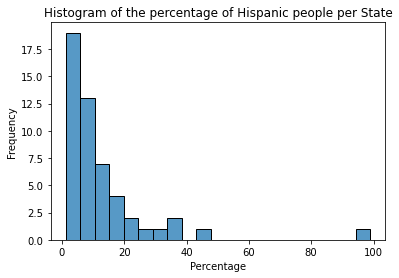

In [23]:
sns.histplot(us_census, x="Hispanic")
plt.title("Histogram of the percentage of Hispanic people per State")
plt.xlabel("Percentage")
plt.ylabel("Frequency")
plt.show()

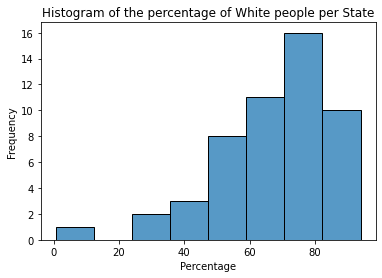

In [24]:
sns.histplot(us_census, x="White")
plt.title("Histogram of the percentage of White people per State")
plt.xlabel("Percentage")
plt.ylabel("Frequency")
plt.show()

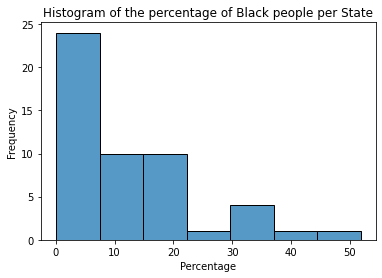

In [25]:
sns.histplot(us_census, x="Black")
plt.title("Histogram of the percentage of Black people per State")
plt.xlabel("Percentage")
plt.ylabel("Frequency")
plt.show()

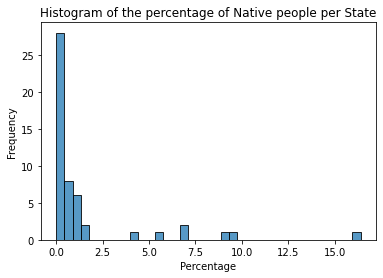

In [26]:
sns.histplot(us_census, x="Native")
plt.title("Histogram of the percentage of Native people per State")
plt.xlabel("Percentage")
plt.ylabel("Frequency")
plt.show()

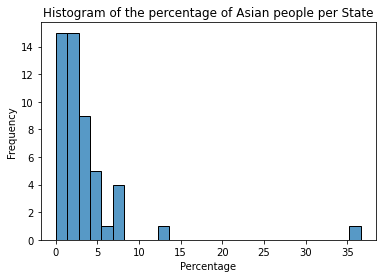

In [27]:
sns.histplot(us_census, x="Asian")
plt.title("Histogram of the percentage of Asian people per State")
plt.xlabel("Percentage")
plt.ylabel("Frequency")
plt.show()

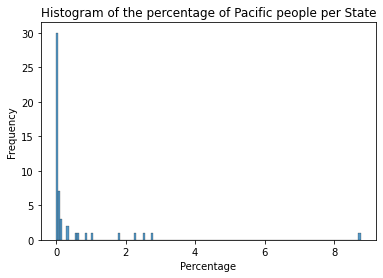

In [28]:
sns.histplot(us_census, x="Pacific")
plt.title("Histogram of the percentage of Pacific people per State")
plt.xlabel("Percentage")
plt.ylabel("Frequency")
plt.show()